In [15]:
%pip install --upgrade tensorflow==2.13.0


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import Sequence

In [18]:
def count_image_files(folder_path):
    # Define possible image file extensions
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp', '.svg')
    image_count = 0

    # Walk through all files in the given folder
    for _, _, files in os.walk(folder_path):
        # Count files with image extensions
        image_count += sum(file.lower().endswith(image_extensions) for file in files)

    return image_count

In [33]:
organic_path = 'BinBot-20231224T045409Z-001\O'
inorganic_path = 'BinBot-20231224T045409Z-001\R'
B3_path = 'BinBot-20231224T045409Z-001\B3 Waste'

In [19]:
organic_path_count = count_image_files(organic_path)
inorganic_path_count = count_image_files(inorganic_path)
B3_path_count = count_image_files(B3_path)

print("organic count: " , organic_path_count)
print("inorganic count: " , inorganic_path_count)
print("b3 count: " , B3_path_count)

organic count:  13966
inorganic count:  11111
b3 count:  10822


In [7]:
def get_image_file_paths(images_directory):
    file_paths = []
    for root, _, files in os.walk(images_directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                file_paths.append(os.path.join(root, file))
    return file_paths

# Get file paths
organic_paths = get_image_file_paths(organic_path)
inorganic_paths = get_image_file_paths(inorganic_path)
B3_paths = get_image_file_paths(B3_path)

# Assign labels
organic_labels = [0] * len(organic_paths)
inorganic_labels = [1] * len(inorganic_paths)
B3_labels = [2] * len(B3_paths)

# Combine paths and labels
all_paths = organic_paths + inorganic_paths + B3_paths
all_labels = organic_labels + inorganic_labels + B3_labels

In [34]:
# Create a DataFrame from your paths and labels
df = pd.DataFrame({
    'file_path': all_paths,
    'label': all_labels
})

# Shuffle and split the DataFrame into training and testing
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

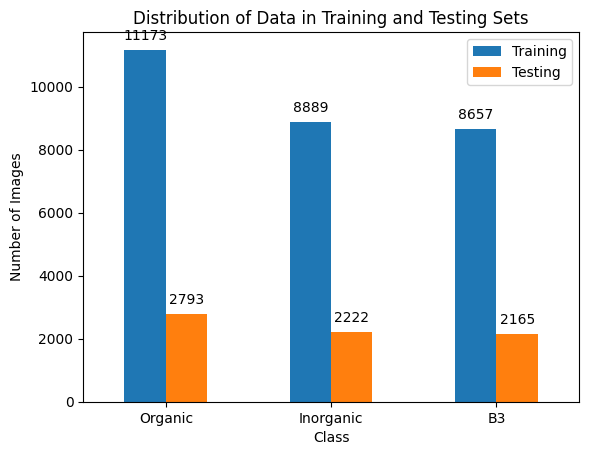

In [9]:
# Count the number of images in each class for the training and testing sets
train_class_counts = train_df['label'].value_counts().sort_index()
test_class_counts = test_df['label'].value_counts().sort_index()

# Create a DataFrame for plotting
class_counts_df = pd.DataFrame({
    'Training': train_class_counts,
    'Testing': test_class_counts
})
class_counts_df.index = ['Organic', 'Inorganic', 'B3']  # Rename the index to class names

# Plotting
ax = class_counts_df.plot(kind='bar')
plt.title('Distribution of Data in Training and Testing Sets')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.xticks(rotation=0)

# Adding the text annotations on each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


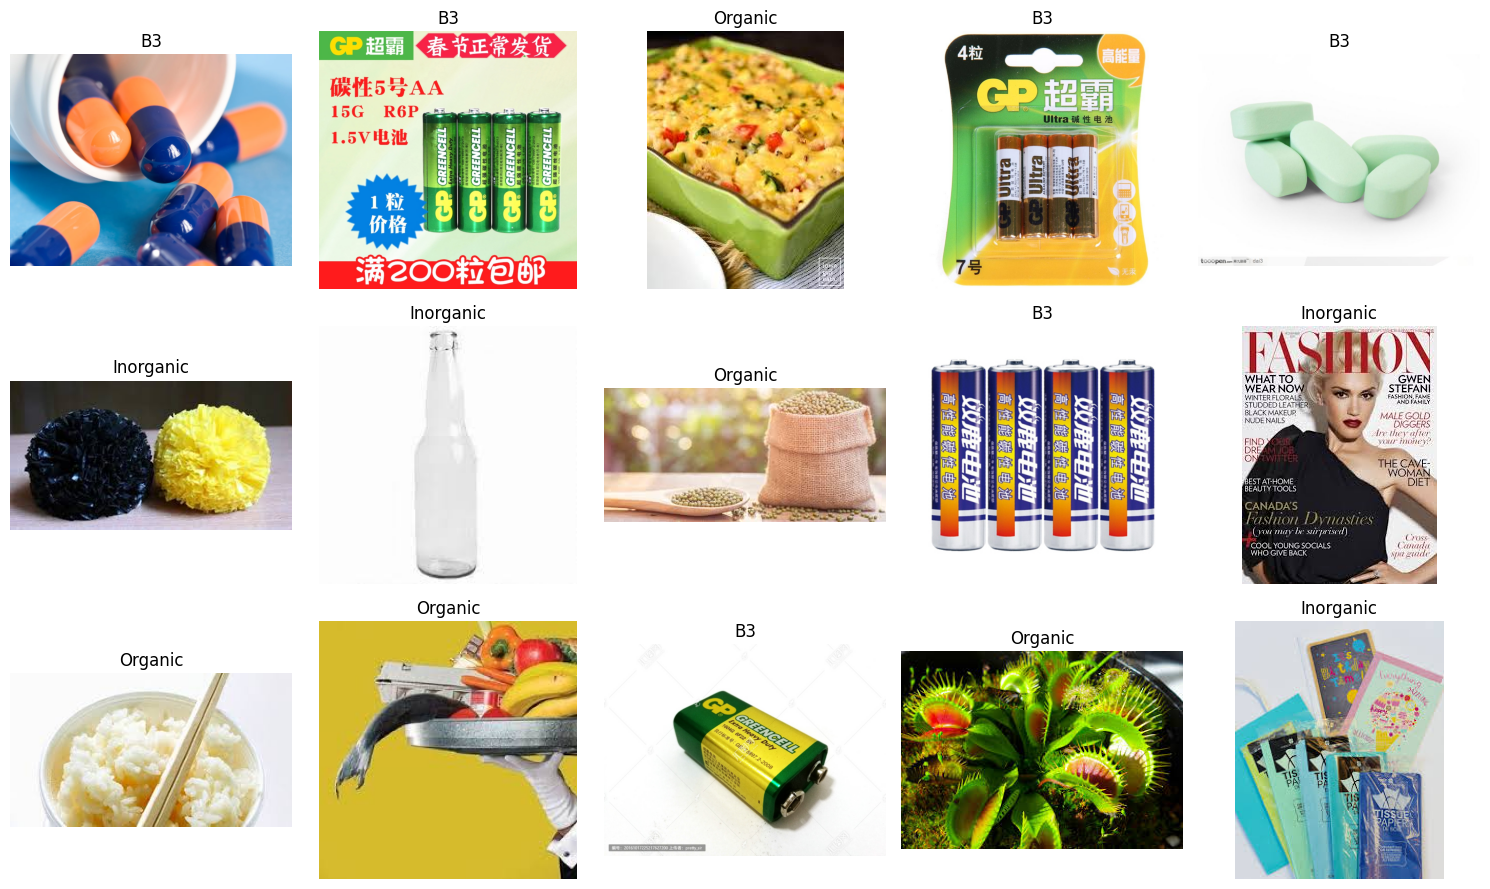

In [ ]:
import random

# Randomly select 15 images from the training set
sample_images = train_df.sample(n=15, random_state=42)

# Plotting
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    # Get the file path and label
    img_path = sample_images.iloc[i]['file_path']
    label = sample_images.iloc[i]['label']
    label_name = 'Organic' if label == 0 else 'Inorganic' if label == 1 else 'B3'

    # Load and display the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [37]:
# Enhanced ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for testing (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, image_data_generator, target_size, batch_size, shuffle=True):
        self.dataframe = dataframe
        self.image_data_generator = image_data_generator
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

    def __getitem__(self, idx):
        # Calculate starting and ending indices for the batch
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.dataframe))

        X = []
        y = []

        current_idx = start
        while len(X) < self.batch_size and current_idx < len(self.dataframe):
            row = self.dataframe.iloc[current_idx]
            try:
                img = load_img(row.file_path, target_size=self.target_size)
                img = img_to_array(img)
                img = self.image_data_generator.random_transform(img)
                img = self.image_data_generator.standardize(img)
                X.append(img)
                y.append(row.label)
            except Exception as e:
                print(f"Error with image: {row.file_path} - {str(e)}")
                # Skip this image and label
            current_idx += 1

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

# Create data generators
train_generator = CustomDataGenerator(train_df, train_datagen, target_size=(224, 224), batch_size=32)
test_generator = CustomDataGenerator(test_df, test_datagen, target_size=(224, 224), batch_size=32, shuffle=False)


# Modeling

In [38]:
# Define DenseNet121 as the base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of DenseNet121
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 7s 1us/step


# Training

In [39]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=np.ceil(len(train_df) / 32),
    epochs=10,
    validation_data=test_generator,
    validation_steps=np.ceil(len(test_df) / 32)
)

Epoch 1/10
 61/898 [=>............................] - ETA: 10:55 - loss: 0.6793 - accuracy: 0.7520

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


898/898 [==============================] - 812s 900ms/step - loss: 0.3542 - accuracy: 0.8673 - val_loss: 0.2662 - val_accuracy: 0.8997
Epoch 2/10
898/898 [==============================] - 777s 865ms/step - loss: 0.2485 - accuracy: 0.9064 - val_loss: 0.2167 - val_accuracy: 0.9208
Epoch 3/10
898/898 [==============================] - 786s 876ms/step - loss: 0.2125 - accuracy: 0.9214 - val_loss: 0.2287 - val_accuracy: 0.9177
Epoch 4/10
898/898 [==============================] - 889s 991ms/step - loss: 0.1819 - accuracy: 0.9332 - val_loss: 0.1995 - val_accuracy: 0.9283
Epoch 5/10
898/898 [==============================] - 765s 852ms/step - loss: 0.1691 - accuracy: 0.9374 - val_loss: 0.2538 - val_accuracy: 0.9170
Epoch 6/10
898/898 [==============================] - 752s 837ms/step - loss: 0.1461 - accuracy: 0.9466 - val_loss: 0.1996 - val_accuracy: 0.9294
Epoch 7/10
898/898 [==============================] - 764s 851ms/step - loss: 0.1236 - accuracy: 0.9549 - val_loss: 0.2102 - val_accura

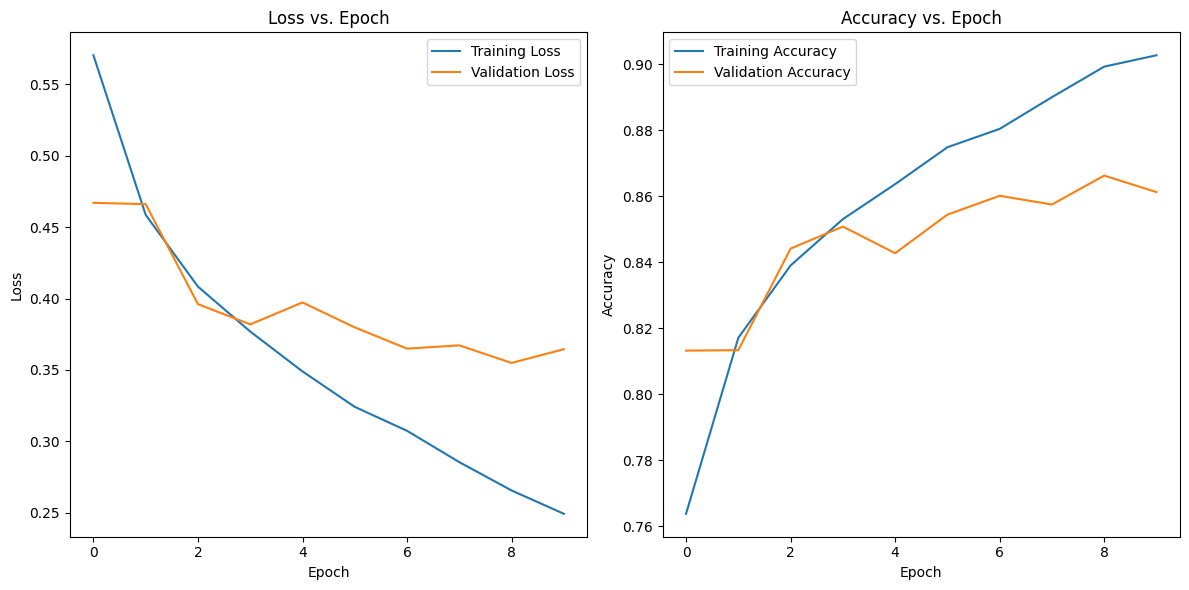

In [63]:

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MSE
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save/Load Model

In [40]:
# Specify the path to the directory where you want to save the model
model_save_path = 'mobilenetkeras/model.keras'

# Save the entire model to a HDF5 file
model.save(model_save_path)

In [42]:
# Replace this with the path to your saved model
model_path = 'mobilenetkeras/model.keras'

model = tf.keras.models.load_model(model_path)


In [43]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimizations, if desired (optional)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
tflite_model_path = 'mobilenet/model.tflite'

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpv1gf286z\assets


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpv1gf286z\assets


In [ ]:
tflite_model_path = 'mobilenet/model.tflite'

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


In [71]:
from sklearn.metrics import confusion_matrix
# Generate predictions for the test set
 # Resetting generator to ensure consistent order
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Function to plot confusion matrix (optional)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting the confusion matrix
plot_confusion_matrix(cm, classes=['Class1', 'Class2', 'Class3'])  # Replace with your class names
plt.show()

  2/225 [..............................] - ETA: 15:46

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


225/225 [==============================] - 815s 4s/step


AttributeError: 'CustomDataGenerator' object has no attribute 'classes'

1/1 [==============================] - 0s 150ms/step
Probabilities:
Organic: 100.00%
Inorganic: 0.00%
B3: 0.00%


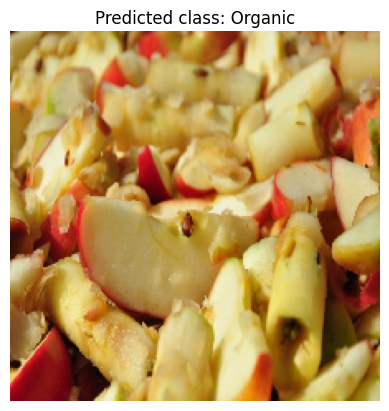

In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Path to your image
image_path = 'Apple-cider-waste-to-snacks-UK-NPD-specialist-develops-process.png'

# Load and preprocess the image
img = load_img(image_path, target_size=(224, 224))  # Ensure the target size is same as model's input size
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Rescale the same way as you did for the training data

# Make a prediction
prediction = model.predict(img_array)

# Get predicted class and probabilities
predicted_class = np.argmax(prediction, axis=1)
class_names = ['Organic', 'Inorganic', 'B3']  # Class names as per your categories
class_probabilities = prediction[0]  # Probabilities for each class

# Output the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and labels
plt.title(f"Predicted class: {class_names[predicted_class[0]]}")

# Print the probabilities for each class
print("Probabilities:")
for class_name, probability in zip(class_names, class_probabilities):
    print(f"{class_name}: {probability*100:.2f}%")

plt.show()


In [2]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load your Keras model
keras_model = load_model('BinBotVGG16model.keras')

# Save the model in TensorFlow's SavedModel format
tf.saved_model.save(keras_model, 'tensorflow format')






INFO:tensorflow:Assets written to: tensorflow format\assets


INFO:tensorflow:Assets written to: tensorflow format\assets


In [3]:
tf.__version__

'2.15.0'

In [2]:
from tensorflow.keras.models import load_model

# Load your model
model = load_model('BinBotVGG16model.keras')

# Get input layer name
input_name = model.input.name
print("Input name:", input_name)



Input name: input_4


In [30]:
import tensorflow as tf

# Replace this with the path to your saved model
model_path = 'BinBotVGG16model'

# Load the model
model = tf.keras.models.load_model(model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
tflite_model_path = 'tflite/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpbghhnrdq\assets


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpbghhnrdq\assets


In [7]:
import tensorflow as tf

# Replace this with the path to your Keras model file
keras_model_path = 'mobilenetkeras\model.keras'

model = tf.keras.models.load_model(keras_model_path)
# # Replace this with the desired path to save the SavedModel
# saved_model_path = 'mobilenet_savedmodel_format'

# model.save(saved_model_path, save_format='tf')



ValueError: Layer 'Conv1' expected 1 variables, but received 0 variables during loading. Expected: ['Conv1/kernel:0']

In [5]:
tf.__version__

'2.13.0'